In [1]:
from tensorflow.keras.models import load_model

# Load model from file
pen_to_pixel = load_model("pen_to_pixel.keras")
from tensorflow.keras import datasets, layers, models


2025-08-24 01:25:32.886449: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-24 01:25:32.920757: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-08-24 01:25:33.732048: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
I0000 00:00:1755978934.828658   84302 gpu_device.cc:2020] Created device /job:localhost/rep

IndentationError: unindent does not match any outer indentation level (<string>, line 15)

In [21]:
plt.imshow(tf.transpose(tf.image.flip_left_right(image), perm=[1,0]), cmap='gray')
plt.title(f"Label: {img_label}")
plt.axis('off')
plt.show()

NameError: name 'image' is not defined

In [5]:
import tensorflow as tf
from tensorflow.keras import layers, models
import tensorflow_datasets as tfds
from tensorflow.keras.callbacks import ModelCheckpoint

# Load EMNIST Digits
ds_train, ds_test = tfds.load('emnist/digits', split=['train', 'test'], as_supervised=True)

# Preprocess function
def preprocess(image, label):
    image = tf.cast(image, tf.float32) / 255.0           # normalize
    image = tf.image.resize(image, [64,64])              # resize
    image = tf.expand_dims(image, -1)                    # add channel dimension
    return image, label

# Shuffle and batch the training dataset
ds_train = ds_train.map(preprocess)
ds_train = ds_train.shuffle(buffer_size=10000, seed=42)  # shuffle the dataset
ds_train = ds_train.batch(128).prefetch(tf.data.AUTOTUNE)

# Test dataset (no shuffle needed)
ds_test = ds_test.map(preprocess).batch(128).prefetch(tf.data.AUTOTUNE)

# Build CNN+RNN model
inputs = layers.Input(shape=(64,64,1))
x = layers.Conv2D(32, 3, activation='relu')(inputs)
x = layers.MaxPooling2D()(x)
x = layers.Conv2D(64, 3, activation='relu')(x)
x = layers.MaxPooling2D()(x)

# Compute the new shape dynamically for RNN
shape = x.shape  # TensorShape(None, 15, 15, 64)  after two MaxPool
timesteps = shape[1]*shape[2]  # 15*15=225
features  = shape[3]           # 64

x = layers.Reshape((timesteps, features))(x)
x = layers.SimpleRNN(128, activation='relu')(x)
x = layers.Dense(64, activation='relu')(x)
outputs = layers.Dense(10, activation='softmax')(x)

pen_to_pixel = models.Model(inputs, outputs)
pen_to_pixel.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
pen_to_pixel.summary()

checkpoint = ModelCheckpoint("pen_to_pixel.keras",
                             monitor="val_accuracy",
                             save_best_only=True,
                             verbose=1)

# Train
pen_to_pixel.fit(ds_train, epochs=20, validation_data=ds_test,callbacks=[checkpoint])

# Evaluate
test_loss, test_acc = pen_to_pixel.evaluate(ds_test)
print(f"EMNIST Digits Test Accuracy: {test_acc*100:.2f}%")


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 64, 64, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 62, 62, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 196, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ (None, 128)            │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 52,426 (204.79 KB)

 Trainable params: 52,426 (204.79 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20


2025-08-24 20:04:10.111967: I external/local_xla/xla/service/service.cc:163] XLA service 0x7ad1bc006e80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-08-24 20:04:10.111985: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 2050, Compute Capability 8.6
2025-08-24 20:04:10.147150: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-08-24 20:04:10.308977: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91200
2025-08-24 20:04:10.357885: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-08-24 20:04:10.357921: I e

   2/1875 ━━━━━━━━━━━━━━━━━━━━ 2:10 70ms/step - accuracy: 0.0996 - loss: 2.3043  

I0000 00:00:1756046060.061991    4593 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1875/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.6222 - loss: 1.1057

2025-08-24 20:05:38.079471: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-08-24 20:05:38.079500: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-08-24 20:05:38.079511: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-08-24 20:05:39.138748: I external/l


Epoch 1: val_accuracy improved from None to 0.81785, saving model to pen_to_pixel.keras
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 91s 43ms/step - accuracy: 0.7548 - loss: 0.7483 - val_accuracy: 0.8178 - val_loss: 0.5636
Epoch 2/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.8764 - loss: 0.4116
Epoch 2: val_accuracy improved from 0.81785 to 0.91953, saving model to pen_to_pixel.keras
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 73s 39ms/step - accuracy: 0.8929 - loss: 0.3650 - val_accuracy: 0.9195 - val_loss: 0.2712
Epoch 3/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.4539 - loss: 2.0700
Epoch 3: val_accuracy did not improve from 0.91953
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 72s 39ms/step - accuracy: 0.5676 - loss: 1.3298 - val_accuracy: 0.6998 - val_loss: 0.8788
Epoch 4/20
1874/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.7131 - loss: 0.8428
Epoch 4: val_accuracy did not improve from 0.91953
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 74s 39ms/step - accuracy: 0.7400 - loss: 0.7751 - val_acc

In [1]:
import tensorflow as tf
print(tf.__version__)


2025-08-24 12:06:27.836869: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-24 12:06:28.038561: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-08-24 12:06:29.033889: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


2.20.0


In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow_datasets as tfds
import string

# ============================
# Load EMNIST ByClass (62 classes: 0–9, A–Z, a–z)
# ============================
(ds_train, ds_test), ds_info = tfds.load(
    'emnist/byclass',
    split=['train', 'test'],
    as_supervised=True,
    with_info=True
)

# ============================
# Preprocessing
# ============================
IMG_SIZE = 64
BATCH_SIZE = 128

def preprocess(image, label):
    image = tf.cast(image, tf.float32) / 255.0
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    image = tf.expand_dims(image, -1)  # add channel dimension
    return image, label

ds_train = ds_train.map(preprocess).shuffle(50000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
ds_test = ds_test.map(preprocess).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

NUM_CLASSES = ds_info.features["label"].num_classes  # should be 62

# ============================
# Model
# ============================
def build_model():
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 1))
    x = layers.Conv2D(64, (3,3), activation="relu", padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2,2))(x)

    x = layers.Conv2D(128, (3,3), activation="relu", padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2,2))(x)

    x = layers.Conv2D(256, (3,3), activation="relu", padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2,2))(x)

    x = layers.Flatten()(x)
    x = layers.Dense(512, activation="relu")(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(NUM_CLASSES, activation="softmax")(x)

    model = models.Model(inputs, outputs)
    return model

pen_to_pixel = build_model()
pen_to_pixel.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

# ============================
# Checkpoint
# ============================
checkpoint = ModelCheckpoint(
    "pen_to_pixel.keras",
    monitor="val_accuracy",
    save_best_only=True,
    verbose=1
)

# ============================
# Training
# ============================
history = pen_to_pixel.fit(
    ds_train,
    validation_data=ds_test,
    epochs=5,
    callbacks=[checkpoint]
)

# ============================
# Evaluation
# ============================
pen_to_pixel = tf.keras.models.load_model("pen_to_pixel.keras")
test_loss, test_acc = pen_to_pixel.evaluate(ds_test)
print(f"✅ Final Test Accuracy: {test_acc:.4f}")


2025-08-24 22:59:07.793665: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-24 22:59:07.830536: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-08-24 22:59:08.634753: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
I0000 00:00:1756056549.875858   60734 gpu_device.cc:2020] Created device /job:localhost/rep

Epoch 1/5


2025-08-24 22:59:11.533243: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:396] The default buffer size is 262144, which is overridden by the user specified `buffer_size` of 8388608
2025-08-24 22:59:12.082716: I external/local_xla/xla/service/service.cc:163] XLA service 0x7b6a0c0107b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-08-24 22:59:12.082758: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 2050, Compute Capability 8.6
2025-08-24 22:59:12.117083: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-08-24 22:59:12.311830: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91200
2025-08-24 22:59:12.404291: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficien

   2/5453 ━━━━━━━━━━━━━━━━━━━━ 7:35 84ms/step - accuracy: 0.0684 - loss: 7.8617   

I0000 00:00:1756056560.485760   60898 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


5452/5453 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.6989 - loss: 1.0821

2025-08-24 23:06:38.057694: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-08-24 23:06:38.530792: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1334', 4 bytes spill stores, 4 bytes spill loads

2025-08-24 23:06:38.537861: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_880', 12 bytes spill stores, 12 bytes spill loads

2025-08-24 23:06:38.709170: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1506', 112 byte

5453/5453 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.6990 - loss: 1.0820

2025-08-24 23:06:58.831052: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_152', 12 bytes spill stores, 12 bytes spill loads

2025-08-24 23:06:59.079409: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_152', 60 bytes spill stores, 60 bytes spill loads

2025-08-24 23:06:59.367433: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_152', 11756 bytes spill stores, 11088 bytes spill loads




Epoch 1: val_accuracy improved from None to 0.85116, saving model to pen_to_pixel.keras
5453/5453 ━━━━━━━━━━━━━━━━━━━━ 471s 84ms/step - accuracy: 0.7702 - loss: 0.7409 - val_accuracy: 0.8512 - val_loss: 0.4165
Epoch 2/5
5453/5453 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.8317 - loss: 0.4982
Epoch 2: val_accuracy improved from 0.85116 to 0.85987, saving model to pen_to_pixel.keras
5453/5453 ━━━━━━━━━━━━━━━━━━━━ 450s 82ms/step - accuracy: 0.8367 - loss: 0.4787 - val_accuracy: 0.8599 - val_loss: 0.3846
Epoch 3/5
5453/5453 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.8483 - loss: 0.4353
Epoch 3: val_accuracy improved from 0.85987 to 0.86284, saving model to pen_to_pixel.keras
5453/5453 ━━━━━━━━━━━━━━━━━━━━ 451s 83ms/step - accuracy: 0.8508 - loss: 0.4253 - val_accuracy: 0.8628 - val_loss: 0.3857
Epoch 4/5
5453/5453 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.8562 - loss: 0.4067
Epoch 4: val_accuracy improved from 0.86284 to 0.86684, saving model to pen_to_pixel.keras
5453/545

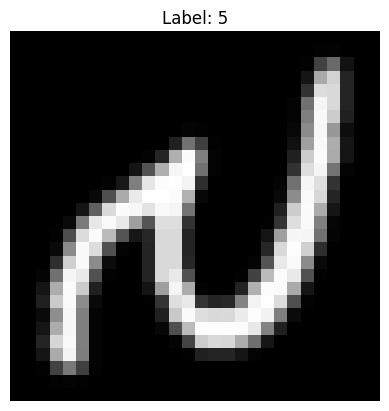

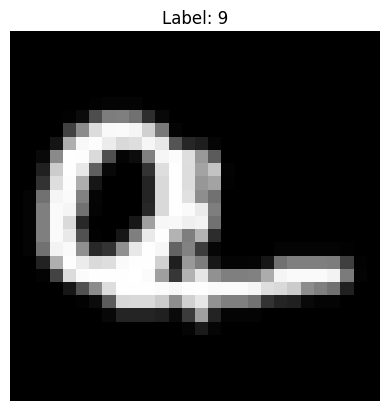

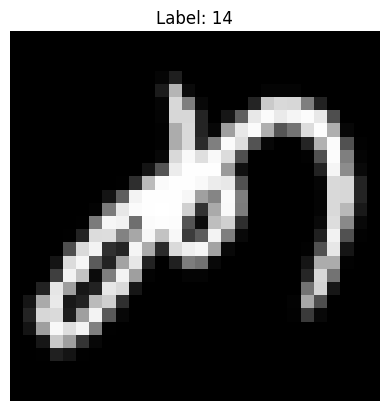

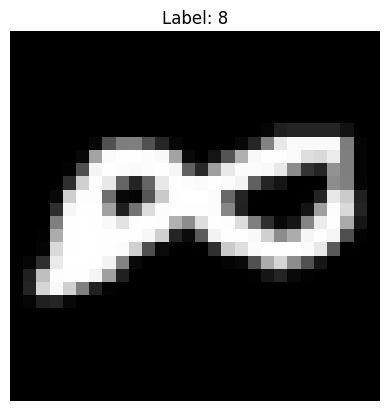

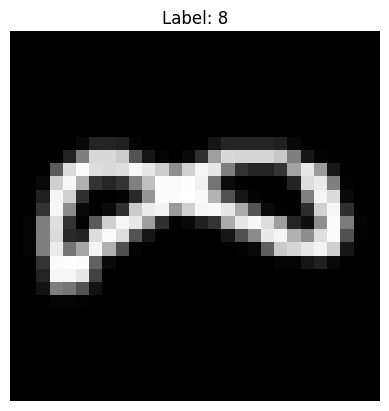

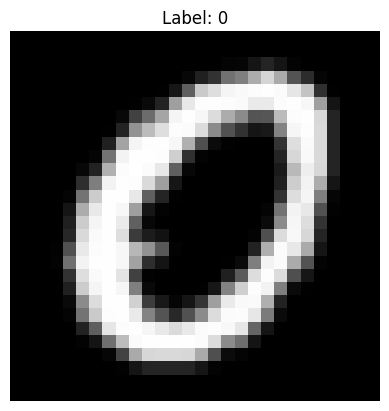

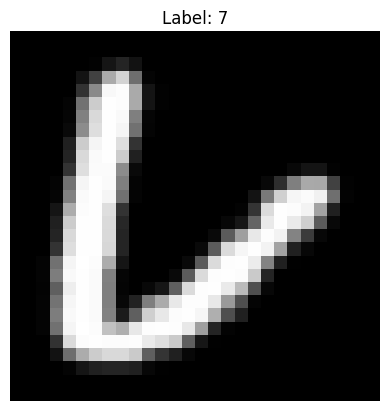

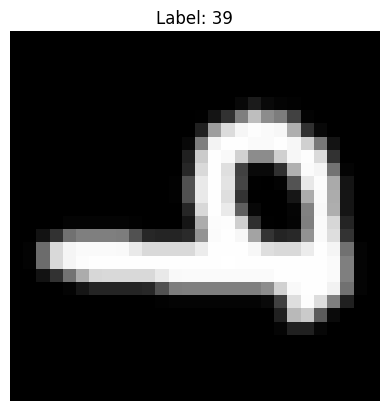

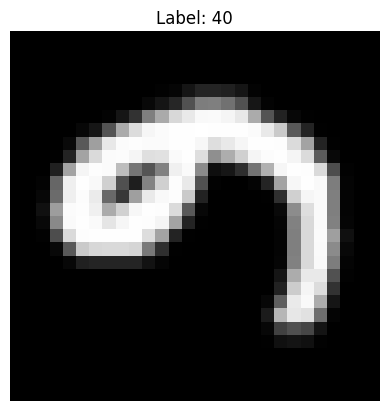

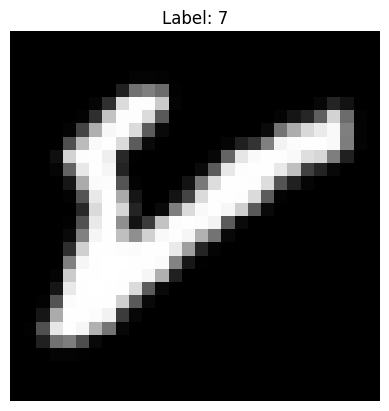

2025-08-24 23:38:03.914900: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

# 🔹 Load EMNIST Letters dataset (you can replace with 'mnist')
ds = tfds.load("emnist/byclass", split="train", as_supervised=True)

# 🔹 Take a single example
for image, label in ds.take(10):
    plt.imshow(tf.squeeze(image), cmap="gray")
    plt.title(f"Label: {label.numpy()}")
    plt.axis("off")
    plt.show()


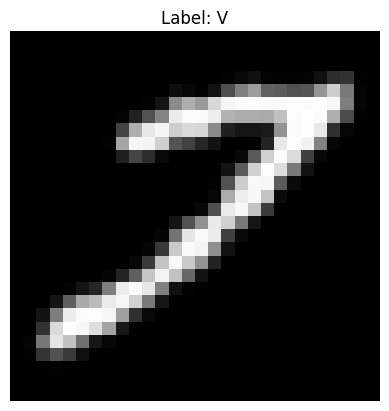

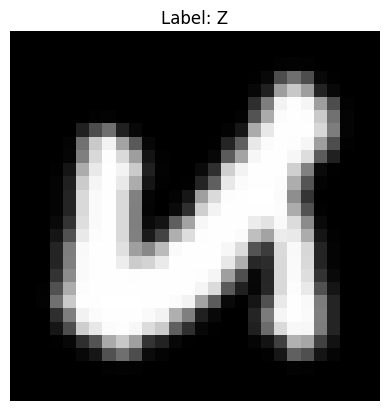

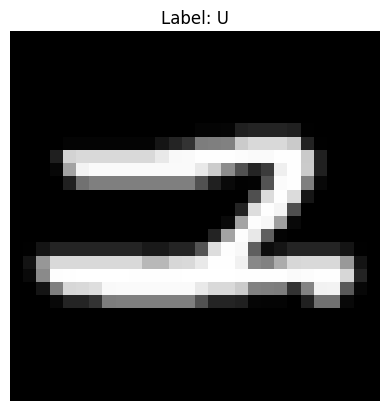

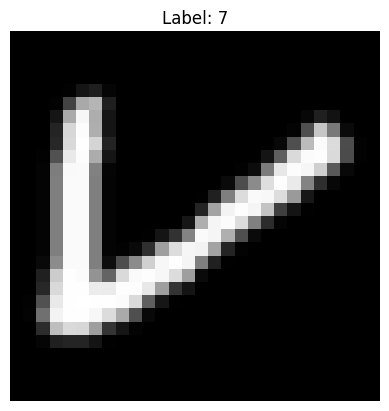

2025-08-24 23:49:29.846328: W tensorflow/core/kernels/data/cache_dataset_ops.cc:917] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


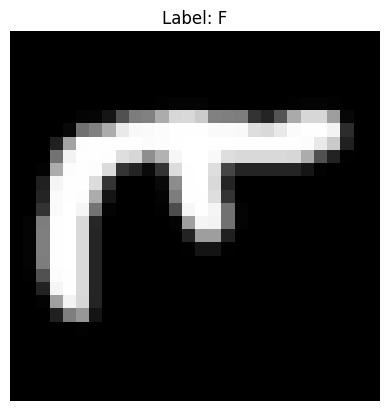

2025-08-24 23:49:29.874751: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [8]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

# 🔹 Load EMNIST Balanced dataset
ds = tfds.load("emnist/balanced", split="train", as_supervised=True)

# 🔹 Class labels for EMNIST Balanced (47 classes)
emnist_labels = [
    "0","1","2","3","4","5","6","7","8","9",  # digits
    "A","B","C","D","E","F","G","H","I","J",
    "K","L","M","N","O","P","Q","R","S","T",
    "U","V","W","X","Y","Z",                   # uppercase
    "a","b","d","e","f","g","h","n","q","r",  # lowercase (merged set)
    "t"
]

# 🔹 Take 5 examples and plot them
for image, label in ds.take(5):
    plt.imshow(tf.squeeze(image), cmap="gray")
    plt.title(f"Label: {emnist_labels[label.numpy()]}")
    plt.axis("off")
    plt.show()



In [9]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow_datasets as tfds

# ============================
# Load EMNIST Balanced (47 classes)
# ============================
(ds_train, ds_test), ds_info = tfds.load(
    'emnist/balanced',
    split=['train', 'test'],
    as_supervised=True,
    with_info=True
)

# ============================
# Preprocessing
# ============================
IMG_SIZE = 64
BATCH_SIZE = 128

def preprocess(image, label):
    image = tf.cast(image, tf.float32) / 255.0
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    image = tf.expand_dims(image, -1)  # add channel dimension
    return image, label

ds_train = ds_train.map(preprocess).shuffle(50000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
ds_test = ds_test.map(preprocess).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

NUM_CLASSES = ds_info.features["label"].num_classes  # should be 47 for balanced

# ============================
# Model
# ============================
def build_model():
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 1))
    x = layers.Conv2D(64, (3,3), activation="relu", padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2,2))(x)

    x = layers.Conv2D(128, (3,3), activation="relu", padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2,2))(x)

    x = layers.Conv2D(256, (3,3), activation="relu", padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2,2))(x)

    x = layers.Flatten()(x)
    x = layers.Dense(512, activation="relu")(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(NUM_CLASSES, activation="softmax")(x)

    model = models.Model(inputs, outputs)
    return model

pen_to_pixel = build_model()
pen_to_pixel.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

# ============================
# Checkpoint
# ============================
checkpoint = ModelCheckpoint(
    "pen_to_pixel.keras",
    monitor="val_accuracy",
    save_best_only=True,
    verbose=1
)

# ============================
# Training
# ============================
history = pen_to_pixel.fit(
    ds_train,
    validation_data=ds_test,
    epochs=15,
    callbacks=[checkpoint]
)

# ============================
# Evaluation
# ============================
pen_to_pixel = tf.keras.models.load_model("pen_to_pixel.keras")
test_loss, test_acc = pen_to_pixel.evaluate(ds_test)
print(f"✅ Final Test Accuracy (Balanced): {test_acc:.4f}")


Epoch 1/15


2025-08-24 23:55:51.067479: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-08-24 23:55:51.501883: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1334', 60 bytes spill stores, 60 bytes spill loads

2025-08-24 23:55:51.715868: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1334', 260 bytes spill stores, 260 bytes spill loads

2025-08-24 23:55:51.782333: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1334', 304

881/882 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.4486 - loss: 2.2626

2025-08-24 23:57:04.983652: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-08-24 23:57:04.983737: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-08-24 23:57:04.983748: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-08-24 23:57:05.484559: I external/l

882/882 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.4488 - loss: 2.2616

2025-08-24 23:57:14.356607: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_152', 12 bytes spill stores, 12 bytes spill loads

2025-08-24 23:57:14.613413: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_152', 60 bytes spill stores, 60 bytes spill loads

2025-08-24 23:57:14.886172: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_152', 11756 bytes spill stores, 11088 bytes spill loads




Epoch 1: val_accuracy improved from None to 0.81378, saving model to pen_to_pixel.keras
882/882 ━━━━━━━━━━━━━━━━━━━━ 88s 94ms/step - accuracy: 0.5927 - loss: 1.4191 - val_accuracy: 0.8138 - val_loss: 0.5498
Epoch 2/15
881/882 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.7413 - loss: 0.7899
Epoch 2: val_accuracy improved from 0.81378 to 0.83819, saving model to pen_to_pixel.keras
882/882 ━━━━━━━━━━━━━━━━━━━━ 73s 83ms/step - accuracy: 0.7572 - loss: 0.7430 - val_accuracy: 0.8382 - val_loss: 0.4841
Epoch 3/15
881/882 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.7929 - loss: 0.6205
Epoch 3: val_accuracy improved from 0.83819 to 0.85723, saving model to pen_to_pixel.keras
882/882 ━━━━━━━━━━━━━━━━━━━━ 73s 83ms/step - accuracy: 0.8003 - loss: 0.5991 - val_accuracy: 0.8572 - val_loss: 0.4230
Epoch 4/15
881/882 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.8177 - loss: 0.5297
Epoch 4: val_accuracy improved from 0.85723 to 0.85856, saving model to pen_to_pixel.keras
882/882 ━━━━━━━━━━━━

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /home/mudda/tensorflow_datasets/emnist/bymerge/incomplete.33OT2A_3.1.0/emnist-train.tfrecord*...:   …

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /home/mudda/tensorflow_datasets/emnist/bymerge/incomplete.33OT2A_3.1.0/emnist-test.tfrecord*...:   0…

Dataset emnist downloaded and prepared to /home/mudda/tensorflow_datasets/emnist/bymerge/3.1.0. Subsequent calls will reuse this data.


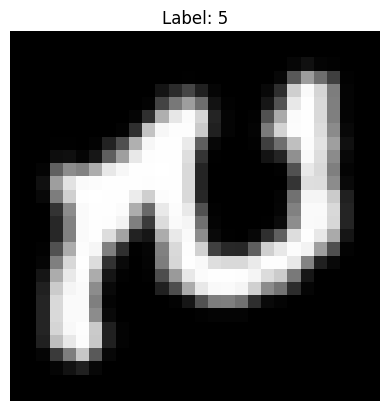

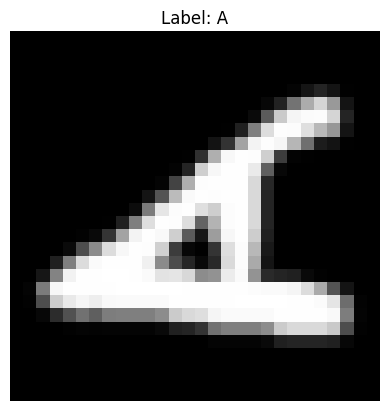

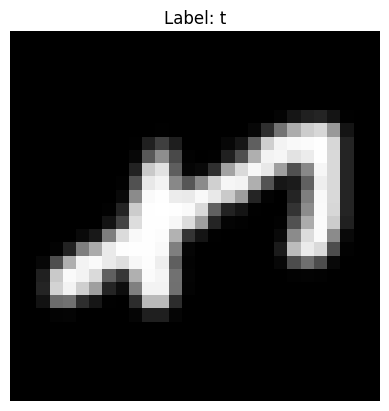

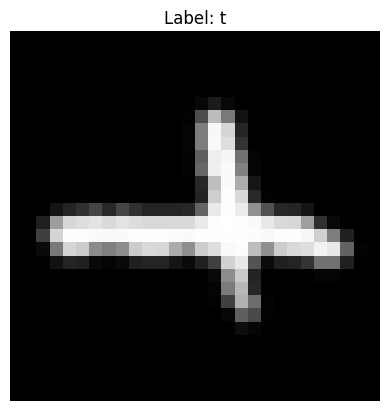

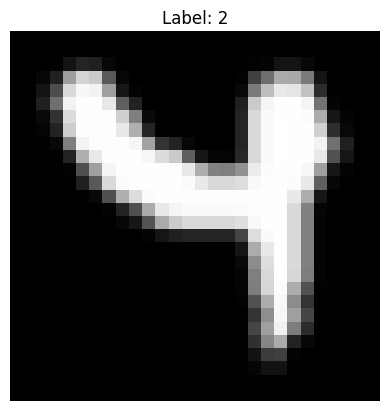

In [12]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

# 🔹 Load EMNIST ByMerge dataset
ds = tfds.load("emnist/bymerge", split="train", as_supervised=True)

# 🔹 Class labels for EMNIST ByMerge (47 classes)
# (Digits + merged uppercase/lowercase letters)
emnist_labels = [
    "0","1","2","3","4","5","6","7","8","9",   # digits
    "A","B","C","D","E","F","G","H","I","J",
    "K","L","M","N","O","P","Q","R","S","T",
    "U","V","W","X","Y","Z",                    # uppercase
    "a","b","d","e","f","g","h","n","q","r",   # lowercase merged
    "t"
]

# 🔹 Take 5 examples and plot them
for image, label in ds.take(5):
    plt.imshow(tf.squeeze(image), cmap="gray")
    plt.title(f"Label: {emnist_labels[label.numpy()]}")
    plt.axis("off")
    plt.show()


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow_datasets as tfds


(ds_train, ds_test), ds_info = tfds.load(
    'emnist/bymerge',
    split=['train', 'test'],
    as_supervised=True,
    with_info=True
)


IMG_SIZE = 64
BATCH_SIZE = 128

def preprocess(image, label):
    image = tf.cast(image, tf.float32) / 255.0
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    image = tf.expand_dims(image, -1)  # add channel dimension
    return image, label

ds_train = ds_train.map(preprocess).shuffle(50000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
ds_test = ds_test.map(preprocess).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

NUM_CLASSES = ds_info.features["label"].num_classes  # should be 47 for bymerge


def build_model():
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 1))
    x = layers.Conv2D(64, (3,3), activation="relu", padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2,2))(x)

    x = layers.Conv2D(128, (3,3), activation="relu", padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2,2))(x)

    x = layers.Conv2D(256, (3,3), activation="relu", padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2,2))(x)

    x = layers.Flatten()(x)
    x = layers.Dense(512, activation="relu")(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(NUM_CLASSES, activation="softmax")(x)

    model = models.Model(inputs, outputs)
    return model

pen_to_pixel = build_model()
pen_to_pixel.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])


checkpoint = ModelCheckpoint(
    "pen_to_pixel.keras",
    monitor="val_accuracy",
    save_best_only=True,
    verbose=1
)

# ============================
# Training
# ============================
history = pen_to_pixel.fit(
    ds_train,
    validation_data=ds_test,
    epochs=20,
    callbacks=[checkpoint]
)

# ============================
# Evaluation
# ============================
pen_to_pixel = tf.keras.models.load_model("pen_to_pixel.keras")
test_loss, test_acc = pen_to_pixel.evaluate(ds_test)
print(f"✅ Final Test Accuracy (ByMerge): {test_acc:.4f}")


Epoch 1/20
 633/5453 ━━━━━━━━━━━━━━━━━━━━ 6:27 80ms/step - accuracy: 0.5114 - loss: 2.1906

In [2]:
import cv2
print(cv2.__version__)


4.12.0


In [3]:
import os
print(os.getcwd())

/home/mudda


In [ ]:
/home/mudda/Downloads/

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
import tensorflow_datasets as tfds
from tensorflow.keras.callbacks import ModelCheckpoint

# Load EMNIST Letters (26 classes: A–Z)
ds_train, ds_test = tfds.load('emnist/letters', split=['train', 'test'], as_supervised=True)

# Preprocess function
def preprocess(image, label):
    image = tf.cast(image, tf.float32) / 255.0           # normalize
    image = tf.image.resize(image, [64,64])              # resize to 64x64
    image = tf.expand_dims(image, -1)                    # add channel dimension
    label = label - 1  # EMNIST Letters labels go from 1–26 → shift to 0–25
    return image, label

# Shuffle function
def shuffle_dataset(dataset, buffer_size=10000, seed=42):
    return dataset.shuffle(buffer_size=buffer_size, seed=seed, reshuffle_each_iteration=True)

# Apply preprocessing + shuffling
ds_train = ds_train.map(preprocess)
ds_train = shuffle_dataset(ds_train)                     # 🔥 shuffle added here
ds_train = ds_train.batch(128).prefetch(tf.data.AUTOTUNE)

# Test dataset (no shuffle needed)
ds_test = ds_test.map(preprocess).batch(128).prefetch(tf.data.AUTOTUNE)

# Build stronger CNN+RNN model
inputs = layers.Input(shape=(64,64,1))

# CNN feature extractor
x = layers.Conv2D(32, 3, activation='relu', padding='same')(inputs)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D()(x)

x = layers.Conv2D(64, 3, activation='relu', padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D()(x)

x = layers.Conv2D(128, 3, activation='relu', padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D()(x)

# Flatten to sequence for RNN
shape = x.shape  # (None, 8, 8, 128)
timesteps = shape[1] * shape[2]  # 8*8=64
features = shape[3]  # 128

x = layers.Reshape((timesteps, features))(x)

# RNN
x = layers.Bidirectional(layers.LSTM(128))(x)

# Dense classifier
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(26, activation='softmax')(x)

# Compile model
pen_to_pixel = models.Model(inputs, outputs)
pen_to_pixel.compile(optimizer='adam',
                     loss='sparse_categorical_crossentropy',
                     metrics=['accuracy'])

pen_to_pixel.summary()

# Checkpoint
checkpoint = ModelCheckpoint("pen_to_pixel.keras",
                             monitor="val_accuracy",
                             save_best_only=True,
                             verbose=1)

# Train
pen_to_pixel.fit(ds_train, epochs=150, validation_data=ds_test, callbacks=[checkpoint])

# Evaluate
test_loss, test_acc = pen_to_pixel.evaluate(ds_test)
print(f"EMNIST Letters Test Accuracy: {test_acc*100:.2f}%")


2025-08-24 13:20:34.591453: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-24 13:20:34.794610: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-08-24 13:20:35.797648: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
I0000 00:00:1756021837.543771    3785 gpu_device.cc:2020] Created device /job:localhost/rep

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 64, 64, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 64, 64, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 64, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 256)            │       263,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 26)             │         6,682 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 429,210 (1.64 MB)

 Trainable params: 428,762 (1.64 MB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/150


2025-08-24 13:20:40.527638: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:396] The default buffer size is 262144, which is overridden by the user specified `buffer_size` of 8388608
2025-08-24 13:20:40.677905: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91200


694/694 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.5510 - loss: 1.4814
Epoch 1: val_accuracy improved from None to 0.86547, saving model to pen_to_pixel.keras
694/694 ━━━━━━━━━━━━━━━━━━━━ 59s 80ms/step - accuracy: 0.7396 - loss: 0.8383 - val_accuracy: 0.8655 - val_loss: 0.4035
Epoch 2/150
694/694 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.8921 - loss: 0.3320
Epoch 2: val_accuracy improved from 0.86547 to 0.90345, saving model to pen_to_pixel.keras
694/694 ━━━━━━━━━━━━━━━━━━━━ 55s 79ms/step - accuracy: 0.9004 - loss: 0.3079 - val_accuracy: 0.9034 - val_loss: 0.2839
Epoch 3/150
694/694 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.9175 - loss: 0.2518
Epoch 3: val_accuracy improved from 0.90345 to 0.91034, saving model to pen_to_pixel.keras
694/694 ━━━━━━━━━━━━━━━━━━━━ 54s 78ms/step - accuracy: 0.9209 - loss: 0.2446 - val_accuracy: 0.9103 - val_loss: 0.2646
Epoch 4/150
694/694 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.9288 - loss: 0.2143
Epoch 4: val_accuracy did not imp

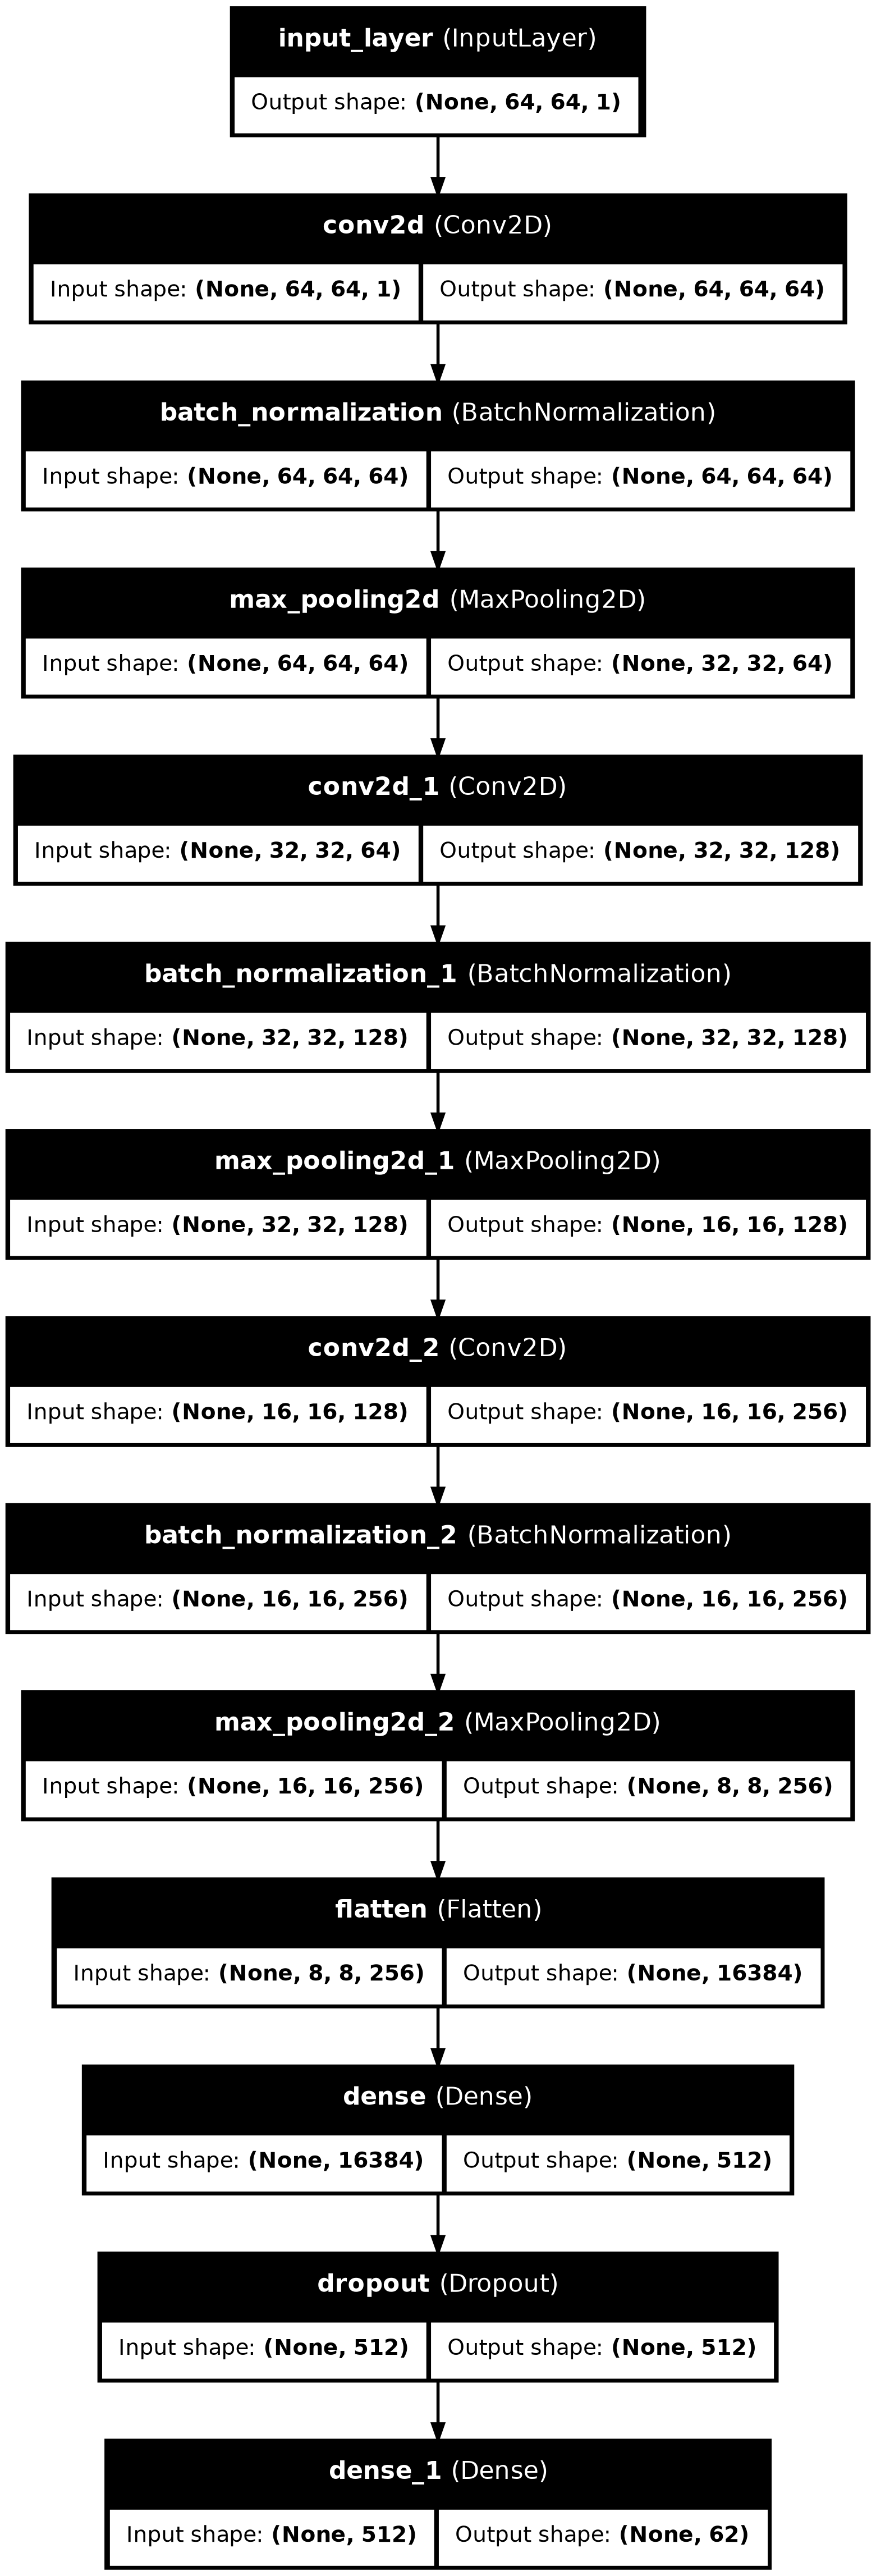

In [6]:
from tensorflow.keras.utils import plot_model

# Save model architecture as an image
plot_model(pen_to_pixel, to_file="pen_to_pixel.png", show_shapes=True, show_layer_names=True)
